# MPO624: Linear Regressions 
### Kelsey Malloy

Objective: learn how to apply linear regression to atmospheric and oceanic data

Input: atmospheric and oceanic data from THREDDS server

Output: figures and values about covariance, correlation, linear regression

### <i>last edited: 01/2020</i>

In [1]:
import numpy as np
import xarray as xr
import tarfile
import os
import shutil
import scipy.stats as ss
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import addcyclic, shiftgrid
from scipy import interpolate

/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Load and process data

In [4]:
# Connect to THREDDS server for ERSST v5 SST data
url_sst = 'https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
print(url_sst)
sst_full_data = xr.open_dataset(url_sst)                   
print(sst_full_data)

https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc


ValueError: netCDF4 or pydap is required for accessing remote datasets via OPeNDAP

In [3]:
# let's only take the tropics, & I only care about 1980-2019
lat_bnds=[30,-30]
lon_bnds=[120,280]
time_bnds=['1990-01-01','2019-12-01']

sst_data = sst_full_data.sel(lat=slice(*lat_bnds),lon=slice(*lon_bnds),time=slice(*time_bnds))
print(sst_data)

<xarray.Dataset>
Dimensions:    (lat: 31, lon: 81, nbnds: 2, time: 360)
Coordinates:
  * lat        (lat) float32 30.0 28.0 26.0 24.0 ... -24.0 -26.0 -28.0 -30.0
  * lon        (lon) float32 120.0 122.0 124.0 126.0 ... 274.0 276.0 278.0 280.0
  * time       (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2019-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    geospatial_lon_min:              -1.0
    geospatial_lon_max

In [4]:
#p=[]
#year_range = np.arange(1990,2019+1,1)            # range of years interested in obtaining, remember python starts counting at 0 so for 10 years we actually need to say through 2005

#for i in year_range:
url_p = 'https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/cmap/enh/precip.mon.mean.nc'    # string subset -->  %.s and % i will insert the i in date_range we are looping through
print(url_p)
precip_full_data = xr.open_dataset(url_p)                 
#    p.append(p1)                                         # append opened files 
    

https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/cmap/enh/precip.mon.mean.nc


In [5]:
print(precip_full_data)

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 492)
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-12-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Conventions:                     COARDS
    title:                           CPC Merged Analysis of Precipitation (in...
    platform:                        Analyses
    source:                          ftp ftp.cpc.ncep.noaa.gov precip/cmap/mo...
    dataset_title:                   CPC Merged Analysis of Precipitation
    documentation:                   https://www.esrl.noaa.gov/psd/data/gridd...
    References:                      https://www.esrl.noaa.gov/psd/data/gridd...
    date_modified:                   26 Feb 2019
    version:                         V2001
    history:                         update 01/20

In [6]:
# only grab what we want that matches above dataset
#for i in range(len(p1)):
precip_data = precip_full_data.sel(lat=slice(*lat_bnds),lon=slice(*lon_bnds),time=slice(*time_bnds))
print(precip_data)

<xarray.Dataset>
Dimensions:  (lat: 24, lon: 64, time: 360)
Coordinates:
  * lat      (lat) float32 28.75 26.25 23.75 21.25 ... -23.75 -26.25 -28.75
  * lon      (lon) float32 121.25 123.75 126.25 128.75 ... 273.75 276.25 278.75
  * time     (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2019-12-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Conventions:                     COARDS
    title:                           CPC Merged Analysis of Precipitation (in...
    platform:                        Analyses
    source:                          ftp ftp.cpc.ncep.noaa.gov precip/cmap/mo...
    dataset_title:                   CPC Merged Analysis of Precipitation
    documentation:                   https://www.esrl.noaa.gov/psd/data/gridd...
    References:                      https://www.esrl.noaa.gov/psd/data/gridd...
    date_modified:                   26 Feb 2019
    version:                         V2001
    history:                         update 01/20

In [7]:
# OPTIONAL - save the data to netCDF4

#sst_data.to_netcdf('ERSST_monthly_1990-2019.nc')
#precip_data.to_netcdf('CMAPprecip_monthly_1990-2019.nc')

sst_data = xr.open_dataset('ERSST_monthly_1990-2019.nc')
precip_data = xr.open_dataset('CMAPprecip_monthly_1990-2019.nc')



# Variance/standard deviation, covariance, correlation (R), and variance explained (R<sup>2</sup>)

### How does SST and precip over tropical Pacific vary in space?

In [8]:
sst_var = sst_data.sst.var(dim='time').values # variance over time dimension
sst_std = sst_data.sst.std(dim='time').values # std dev " " " "

precip_var = precip_data.precip.var(dim='time').values # variance over time dimension
precip_std = precip_data.precip.std(dim='time').values # std dev " " " "

print(sst_var.shape,sst_std.shape)

(31, 81) (31, 81)


C:\Users\kelse\Anaconda3\envs\LB_20190503\lib\site-packages\xarray\core\nputils.py:220: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwds)
C:\Users\kelse\Anaconda3\envs\LB_20190503\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [9]:
lat = sst_data.lat
lon = sst_data.lon

In [10]:
def Map_eqPacific(plabels, mlabels):
    m = Basemap(projection='cyl', llcrnrlon=120, \
        urcrnrlon=360-80,llcrnrlat=-30,urcrnrlat=30, \
        resolution='l')
    m.drawcoastlines(linewidth=1.5)
    m.drawcountries(linewidth=0.0)
    
    parallels=np.arange(-30,30.1,30)
    if plabels == 1:
        m.drawparallels(parallels,labels=[1,0,0,1],color='k')
    else:
        m.drawparallels(parallels,color='k')
        
    meridians=np.arange(120,(360-80)+.1,30.)
    if mlabels == 1:
        m.drawmeridians(meridians,labels=[1,1,0,1],color='k')
    else:
        m.drawmeridians(meridians,color='k')
                        
    return m

In [11]:
cmap='hot_r'
levs = np.arange(0,8+.2,.2)

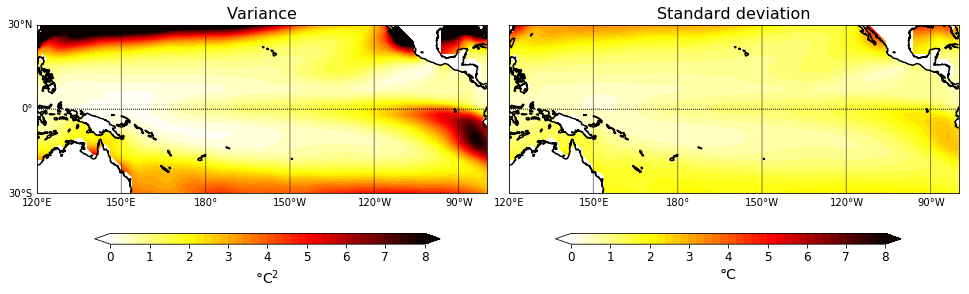

In [12]:
fig = plt.figure(figsize=[16,6])
#st = fig.suptitle('SST variance & standard deviation\n', fontsize=18)

# subplot 1
ax = fig.add_subplot(1,2,1)
m = Map_eqPacific(1,1)
x,y=m(*np.meshgrid(lon,lat))
cs = m.contourf(x, y, sst_var,levs,cmap=cmap,extend='both')
ax.set_title('Variance',fontsize=16)

# subplot 2 
ax2 = fig.add_subplot(1,2,2)
m = Map_eqPacific(0,1)
x,y=m(*np.meshgrid(lon,lat))
cs2 = m.contourf(x, y, sst_std,levs,cmap=cmap,extend='both')
ax2.set_title('Standard deviation',fontsize=16)

# colorbar w/ subplot 1 and 2 
cbaxes = fig.add_axes([0.15, 0.2, 0.3, 0.025])
cb = plt.colorbar(cs,orientation='horizontal', cax = cbaxes)
cb.ax.set_xlabel('\N{DEGREE SIGN}C$^2$',fontsize=14)
cb.ax.tick_params(labelsize=12)  

# colorbar w/ subplot 2
cbaxes2 = fig.add_axes([0.55, 0.2, 0.3, 0.025])
cb2 = plt.colorbar(cs2,orientation='horizontal', cax = cbaxes2)
cb2.ax.set_xlabel('\N{DEGREE SIGN}C',fontsize=14)
cb2.ax.tick_params(labelsize=12)   

# other handles on figure
plt.subplots_adjust(top=0.9,left=0.1,right=0.9,wspace=0.05, hspace=0.1)
plt.show()


In [13]:
latp = precip_data.lat
lonp = precip_data.lon

In [14]:
levs = np.arange(0,16+.4,.4)

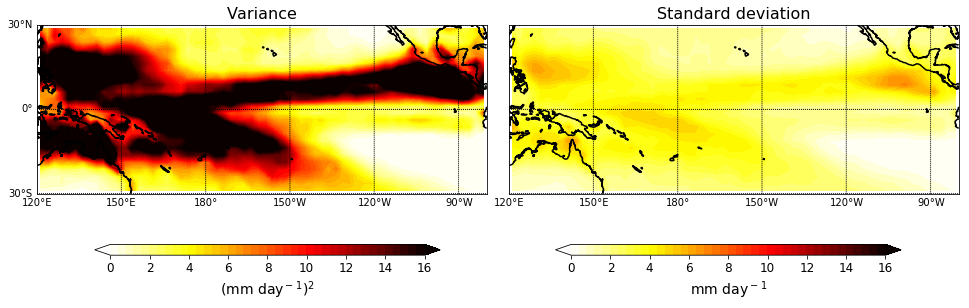

In [15]:
fig = plt.figure(figsize=[16,6])
#st = fig.suptitle('SST variance & standard deviation\n', fontsize=18)

# subplot 1
ax = fig.add_subplot(1,2,1)
m = Map_eqPacific(1,1)
x,y=m(*np.meshgrid(lonp,latp))
cs = m.contourf(x, y, precip_var,levs,cmap=cmap,extend='both')
ax.set_title('Variance',fontsize=16)

# subplot 2 
ax2 = fig.add_subplot(1,2,2)
m =Map_eqPacific(0,1)
x,y=m(*np.meshgrid(lonp,latp))
cs2 = m.contourf(x, y, precip_std,levs,cmap=cmap,extend='both')
ax2.set_title('Standard deviation',fontsize=16)

# colorbar w/ subplot 1 and 2 
cbaxes = fig.add_axes([0.15, 0.2, 0.3, 0.025])
cb = plt.colorbar(cs,orientation='horizontal', cax = cbaxes)
cb.ax.set_xlabel('(mm day$^-$$^1$)$^2$',fontsize=14)
cb.ax.tick_params(labelsize=12)  

# colorbar w/ subplot 2
cbaxes2 = fig.add_axes([0.55, 0.2, 0.3, 0.025])
cb2 = plt.colorbar(cs2,orientation='horizontal', cax = cbaxes2)
cb2.ax.set_xlabel('mm day$^-$$^1$',fontsize=14)
cb2.ax.tick_params(labelsize=12) 

# other handles on figure
plt.subplots_adjust(top=0.95,left=0.1,right=0.9,wspace=0.05, hspace=0.1)



### How does a temporal series of SST and precip along equator covary & correlate in time?

In [16]:
# OPTIONAL - save the data to netCDF4

#sst_data.to_netcdf('ERSST_monthly_1990-2019.nc')
#precip_data.to_netcdf('CMAPprecip_monthly_1990-2019.nc')

sst_data = xr.open_dataset('ERSST_monthly_1990-2019.nc')
precip_data = xr.open_dataset('CMAPprecip_monthly_1990-2019.nc')



In [17]:
# grab values along lat=0N for [time,lon] array

#print(sst_data.lat)
#sst_lat0 = sst_data.sst.sel(lat=0.,method='nearest').values # variance over time dimension

precip_lat0 = precip_data.precip.sel(lat=0.,method='nearest') # variance over time dimension

print(precip_lat0.shape)

(360, 64)


In [18]:
#interpolation for SST data
sst_lat0 = sst_data.sst.sel(lat=0,method='nearest').interp_like(precip_data.precip.sel(lat=0,method='nearest'))

print(sst_lat0.shape)

(360, 64)


In [19]:
# find anomaly and standardized anomaly

# mask
sst_lat0 = np.ma.masked_invalid(sst_lat0.values)
precip_lat0 = np.ma.masked_invalid(precip_lat0.values)

# find std dev
sst_std = sst_lat0.std(axis=0)
precip_std = precip_lat0.std(axis=0)
print(sst_std,precip_std)

# find anom
sst_lat0_anom = np.ma.anom(sst_lat0,axis=0)
precip_lat0_anom = np.ma.anom(precip_lat0,axis=0)
    
# divide by std dev
sst_lat0_stdanom = sst_lat0_anom / sst_std
precip_lat0_stdanom = precip_lat0_anom / precip_std

# reshape
#sst_lat0_r = np.ma.reshape(sst_lat0,(sst_lat0.shape[0]*sst_lat0.shape[1]))
#precip_lat0_r = np.ma.reshape(precip_lat0,(precip_lat0.shape[0]*precip_lat0.shape[1]))

print(sst_lat0_stdanom.shape,precip_lat0_anom.shape)

[0.38594622074040663 0.47372874562416206 0.564483259973999
 0.5254494920820795 0.45206587739678705 0.41356663545674627
 0.4012372277185919 0.4060840754979125 0.40797061546425134
 0.40464466069512717 0.3996016315773976 0.3938950075811241
 0.38686016725477146 0.383338726651706 0.3904874428332379
 0.4163278562666369 0.46990865094601814 0.5381457746019367
 0.6209951129742058 0.7161802312298704 0.7896620147209321
 0.8381669144049596 0.8690927707409981 0.8986941151307246
 0.919025762248692 0.9322781658485177 0.9495441358984622
 0.9766905273083172 1.0145590086967968 1.049553844392605
 1.0642023221970731 1.0688660387943114 1.0677080929501603
 1.0682015252224961 1.0815930597289491 1.1067260575185147
 1.1317873276868307 1.1549264726926336 1.1804728227917358
 1.2138341388919647 1.2460262984482093 1.2673001286557357
 1.2905864229546988 1.3216102949093065 1.361263789722729 1.398818215943117
 1.4348803059645399 1.486056135363492 1.5457020158445876 1.597643958086206
 1.6487223380251037 1.712158309640

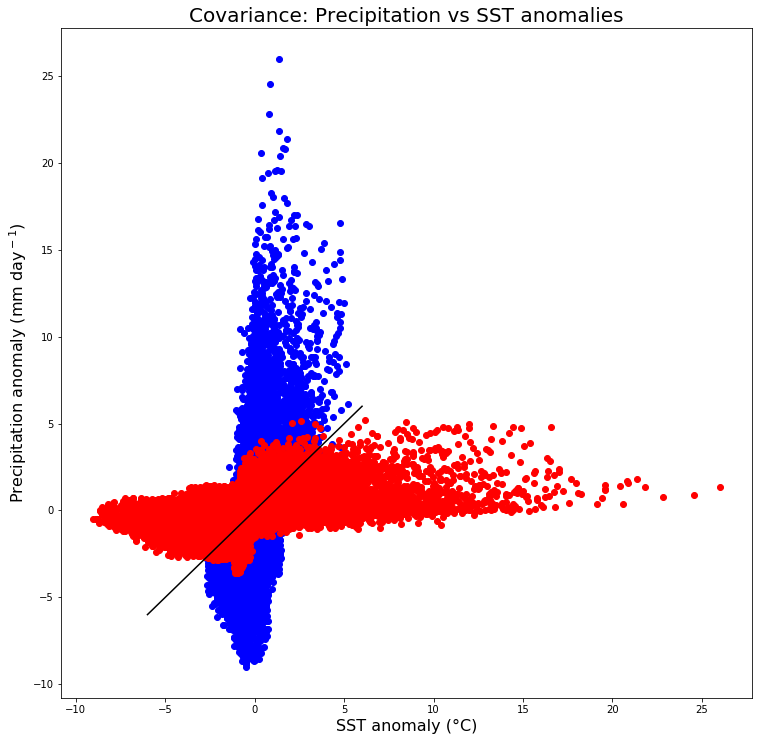

In [20]:
fig = plt.figure(figsize=[12,12])

ax=fig.add_subplot(111)
ax.scatter(sst_lat0_anom,precip_lat0_anom,color='b')
ax.scatter(precip_lat0_anom,sst_lat0_anom,color='r')
ax.plot([-6,6],[-6,6],color='k') # 1:1 line
ax.set_ylabel('Precipitation anomaly (mm day$^-$$^1$)',fontsize=16)
ax.set_xlabel('SST anomaly (\N{DEGREE SIGN}C)',fontsize=16)
ax.set_title('Covariance: Precipitation vs SST anomalies',fontsize=20)
#ax.set_xlim([-8,10])
#ax.set_ylim([-8,10])

plt.subplots_adjust(top=0.9,left=0.1,right=0.9,wspace=0.05, hspace=0.05)


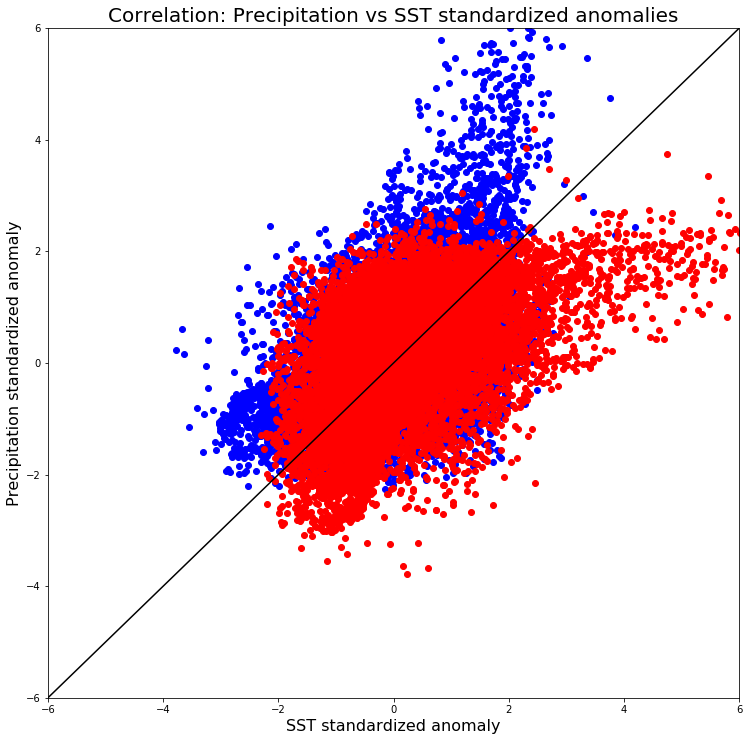

In [21]:
fig = plt.figure(figsize=[12,12])

ax=fig.add_subplot(111)
ax.scatter(sst_lat0_stdanom,precip_lat0_stdanom,color='b')
ax.scatter(precip_lat0_stdanom,sst_lat0_stdanom,color='r')
ax.plot([-6,6],[-6,6],color='k') # 1:1 line
ax.set_ylabel('Precipitation standardized anomaly',fontsize=16)
ax.set_xlabel('SST standardized anomaly',fontsize=16)
ax.set_title('Correlation: Precipitation vs SST standardized anomalies',fontsize=20)
ax.set_xlim([-6,6])
ax.set_ylim([-6,6])

plt.subplots_adjust(top=0.9,left=0.1,right=0.9,wspace=0.05, hspace=0.05)


In [22]:
# reshape
sst_lat0_anom_r = np.ma.reshape(sst_lat0,(sst_lat0.shape[0]*sst_lat0.shape[1]))
precip_lat0_anom_r = np.ma.reshape(precip_lat0,(precip_lat0.shape[0]*precip_lat0.shape[1]))
sst_lat0_stdanom_r = np.ma.reshape(sst_lat0,(sst_lat0.shape[0]*sst_lat0.shape[1]))
precip_lat0_stdanom_r = np.ma.reshape(precip_lat0,(precip_lat0.shape[0]*precip_lat0.shape[1]))

In [23]:
# covariance versus corr coeff

COV = np.cov(sst_lat0_anom_r,precip_lat0_anom_r)
COR = np.corrcoef(sst_lat0_stdanom_r,precip_lat0_stdanom_r)

print('Covariance between SST and precip anoms: '+str(COV))
print('Variance of SST, precip: '+str(np.var(sst_lat0_anom_r,axis=0))+', '+str(np.var(precip_lat0_anom_r,axis=0)))
print('Correlation between SST and precip std anoms: '+str(COR))
print('Explained variance (R squared): ' +str((COR[1,0]**2)*100)+'%')

Covariance between SST and precip anoms: [[ 4.98274924  6.41053904]
 [ 6.41053904 18.14147681]]
Variance of SST, precip: 4.9825329739133135, 18.140689416021733
Correlation between SST and precip std anoms: [[1.         0.67425428]
 [0.67425428 1.        ]]
Explained variance (R squared): 45.461883989383765%


# Example of how to use linear regression

### What happens when we regress a timeseries of Nino 3.4 onto tropical Pacific precipitation pattern?

In [24]:
# calculate a timeseries of STANDARDIZED Nino 3.4 index
lat_bnds = [5,-5]
lon_bnds = [360-170,360-120]

# take time series of averaged SST value in EN34 domain
EN34 = sst_data.sst.sel(lat=slice(*lat_bnds),lon=slice(*lon_bnds)).mean(dim=['lat','lon'],skipna=True).values

# standardize
EN34_stdanom = (EN34 - np.nanmean(EN34)) / np.nanstd(EN34)

print(EN34_stdanom.shape)
    

(360,)


In [25]:
# reshape the precip std anomaly timeseries
precip_stdanom = (precip_data.precip - precip_data.precip.mean(dim='time')) / precip_data.precip.std(dim='time')
precip_stdanom_r = precip_stdanom.values.reshape(precip_stdanom.shape[0],precip_stdanom.shape[1]*precip_stdanom.shape[2])

print(precip_stdanom_r.shape)

(360, 1536)


In [26]:
def regress_many(x, y, axis=0):
    """
    Regress y on x.

    x is a 1-D array or masked array with n points.
    y is at least 1-D, with n points along the dimension
    specified by axis.

    Returns (b1, r), where b1 is the slope and r is the correlation
    coefficient.

    NOT MINE
    """
    # Allow masked arrays and ordinary arrays, and remove the means.
    x = np.asanyarray(x)
    #x -= x.mean()
    y = np.asanyarray(y)
    #y -= y.mean(axis=axis)
    
    # Black magic to accomodate any dimensionality of y:
    bc = tuple([slice(None) if i == axis else np.newaxis 
               for i in range(y.ndim)])
    
    # Note that we need only sums of squares and products.
    Sxx = (x**2).sum()
    Syy = (y**2).sum(axis=axis)
    Sxy = (x[bc] * y).sum(axis=axis)
    
    r = Sxy / np.ma.sqrt(Sxx * Syy)
    b1 = Sxy / Sxx
    
    return b1, r

In [27]:
# calculate regression 
reg_EN34_precip,r = regress_many(EN34_stdanom,precip_stdanom_r)

# reshape back to lat and lon
reg_EN34_precip = reg_EN34_precip.reshape(precip_stdanom.shape[1],precip_stdanom.shape[2])

In [28]:
latp = precip_data.lat
lonp = precip_data.lon

In [29]:
cmap = 'BrBG'
rlevs = np.arange(-1,1+0.05,.05)

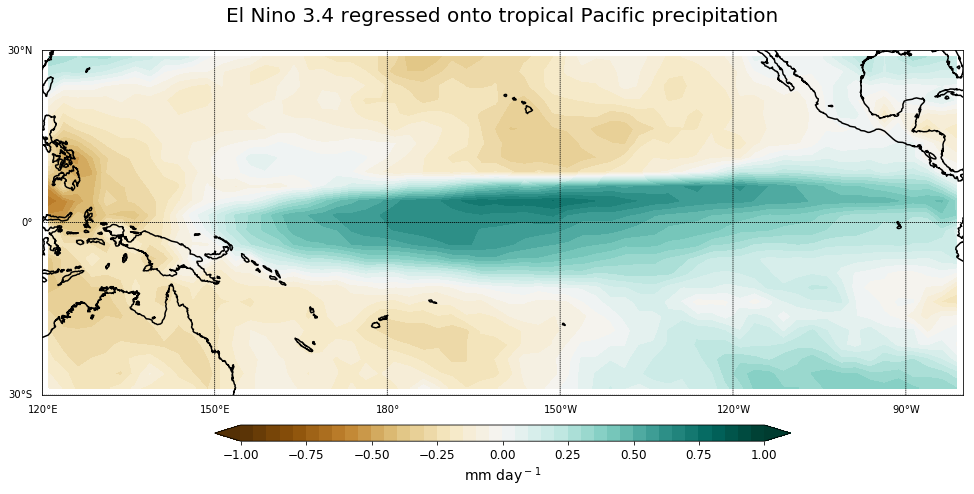

In [30]:
fig = plt.figure(figsize=[16,9])

# subplot 1
ax = fig.add_subplot(111)
m = Map_eqPacific(1,1)
x,y=m(*np.meshgrid(lonp,latp))
cs = m.contourf(x, y, reg_EN34_precip,rlevs,cmap=cmap,extend='both')
ax.set_title('El Nino 3.4 regressed onto tropical Pacific precipitation\n',fontsize=20)

# colorbar w/ subplot 1 
cbaxes = fig.add_axes([0.25, 0.2, 0.5, 0.025])
cb = plt.colorbar(cs,orientation='horizontal', cax = cbaxes)
cb.ax.set_xlabel('mm day$^-$$^1$',fontsize=14)
cb.ax.tick_params(labelsize=12)  


# other handles on figure
plt.subplots_adjust(top=0.95,left=0.1,right=0.9,wspace=0.05, hspace=0.1)

